# Conditional vs Unconditional GFlowNet Comparison

This notebook compares the performance of conditional and unconditional GFlowNets for mRNA design across different weight configurations.

## Objectives:
1. Train both conditional and unconditional GFlowNets
2. Evaluate performance across different weight configurations
3. Analyze when conditional GFlowNet outperforms unconditional
4. Visualize training losses and evaluation rewards

In [38]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from utils import *
from simple_reward_function import compute_simple_reward
from env import CodonDesignEnv
from preprocessor import CodonSequencePreprocessor
from train import train_conditional_gfn, train
from evaluate import evaluate_conditional, evaluate
from plots import *
from gfn.gflownet import TBGFlowNet, SubTBGFlowNet
from gfn.estimators import (
    ConditionalDiscretePolicyEstimator,
    ConditionalScalarEstimator,
    ScalarEstimator,
    DiscretePolicyEstimator,
)
from gfn.utils.modules import MLP
from gfn.samplers import Sampler

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [39]:
class Config:

    def __init__(self):

        # Training parameters
        self.n_iterations = 200
        self.batch_size = 8
        self.lr = 0.005
        self.lr_logz = 0.1
        self.epsilon = 0.25
        self.subTB_lambda = 0.8

        # Model parameters
        self.embedding_dim = 32
        self.hidden_dim = 128
        self.n_hidden = 2
        self.tied = True

        # Evaluation parameters
        self.n_samples = 50
        self.top_n = 20

        # Protein sequence
        self.protein_seq = 'MDSEVQRDGRILDLIDDAWREDKLPYEDVAIPLNELPEPEQDNGGTTESVKEQEMKWTDLALQYLHENVPPIGN*'

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()
print(f"Using device: {config.device}")
print(f"Protein sequence length: {len(config.protein_seq)}")

Using device: cuda
Protein sequence length: 75


In [40]:
# Model Building Functions
def build_unconditional_gflownet(env, preprocessor, config):
    """Build unconditional GFlowNet model."""

    # Policy modules
    module_PF = MLP(
        input_dim=preprocessor.output_dim,
        output_dim=env.n_actions,
        hidden_dim=config.hidden_dim,
        n_hidden_layers=config.n_hidden,
    )

    module_PB = MLP(
        input_dim=preprocessor.output_dim,
        output_dim=env.n_actions - 1,
        hidden_dim=config.hidden_dim,
        n_hidden_layers=config.n_hidden,
        trunk=module_PF.trunk if config.tied else None,
    )


    # Estimators
    pf_estimator = DiscretePolicyEstimator(
        module_PF,
        env.n_actions,
        preprocessor=preprocessor,
        is_backward=False,
    )
    pb_estimator = DiscretePolicyEstimator(
        module_PB,
        env.n_actions,
        preprocessor=preprocessor,
        is_backward=True,
    )

    # LogF estimator
    module_logF = MLP(
        input_dim=preprocessor.output_dim,
        output_dim=1,
        hidden_dim=config.hidden_dim,
        n_hidden_layers=1,
    )
    logF_estimator = ScalarEstimator(module=module_logF, preprocessor=preprocessor)

    gflownet = SubTBGFlowNet(logF=logF_estimator, pf=pf_estimator, pb=pb_estimator, lamda=config.subTB_lambda)
    return gflownet, pf_estimator, pb_estimator


def build_conditional_gflownet(env, preprocessor, config):
    """Build conditional GFlowNet model."""
    CONCAT_SIZE = 16

    # Policy modules
    module_PF = MLP(
        input_dim=preprocessor.output_dim,
        output_dim=CONCAT_SIZE,
        hidden_dim=config.hidden_dim,
        n_hidden_layers=config.n_hidden,
    )

    module_PB = MLP(
        input_dim=preprocessor.output_dim,
        output_dim=CONCAT_SIZE,
        hidden_dim=config.hidden_dim,
        n_hidden_layers=config.n_hidden,
        trunk=module_PF.trunk if config.tied else None,
    )

    # Conditioning module
    module_cond = MLP(
        input_dim=3,  # Only weights
        output_dim=CONCAT_SIZE,
        hidden_dim=256,
    )

    # Final modules
    module_final_PF = MLP(
        input_dim=CONCAT_SIZE * 2,
        output_dim=env.n_actions,
    )
    module_final_PB = MLP(
        input_dim=CONCAT_SIZE * 2,
        output_dim=env.n_actions - 1,
        trunk=module_final_PF.trunk,
    )

    # Estimators
    pf_estimator = ConditionalDiscretePolicyEstimator(
        module_PF,
        module_cond,
        module_final_PF,
        env.n_actions,
        preprocessor=preprocessor,
        is_backward=False,
    )
    pb_estimator = ConditionalDiscretePolicyEstimator(
        module_PB,
        module_cond,
        module_final_PB,
        env.n_actions,
        preprocessor=preprocessor,
        is_backward=True,
    )

    # LogF estimator
    module_state_logF = MLP(
        input_dim=preprocessor.output_dim,
        output_dim=CONCAT_SIZE,
        hidden_dim=256,
        n_hidden_layers=1,
    )
    module_conditioning_logF = MLP(
        input_dim=3,
        output_dim=CONCAT_SIZE,
        hidden_dim=256,
        n_hidden_layers=1,
    )
    module_final_logF = MLP(
        input_dim=CONCAT_SIZE * 2,
        output_dim=1,
        hidden_dim=256,
        n_hidden_layers=1,
    )
    logF_estimator = ConditionalScalarEstimator(
        module_state_logF,
        module_conditioning_logF,
        module_final_logF,
        preprocessor=preprocessor,
    )

    gflownet = SubTBGFlowNet(logF=logF_estimator, pf=pf_estimator, pb=pb_estimator, lamda=config.subTB_lambda)
    return gflownet, pf_estimator, pb_estimator

print("Model building functions defined!")

Model building functions defined!


In [41]:
def train_unconditional_model(env, gflownet, sampler, config):
    """Train unconditional model with fixed weights."""

    # Use balanced weights for unconditional training
    fixed_weights = [0.33, 0.33, 0.34]
    env.set_weights(fixed_weights)

    non_logz_params = [
        v for k, v in dict(gflownet.named_parameters()).items() if k != "logZ"
    ]
    if "logZ" in dict(gflownet.named_parameters()):
        logz_params = [dict(gflownet.named_parameters())["logZ"]]
    else:
        logz_params = []

    params = [
        {"params": non_logz_params, "lr": config.lr},
        {"params": logz_params, "lr": config.lr_logz},
    ]
    optimizer = torch.optim.Adam(params)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10)

    loss_history = []
    reward_history = []
    unique_sequences = set()

    print("Training unconditional model...")

    for it in tqdm(range(config.n_iterations), desc="Unconditional Training"):

        trajectories = gflownet.sample_trajectories(
            env,
            n=config.batch_size,
            save_logprobs=True,
            save_estimator_outputs=True,
            epsilon=config.epsilon,
        )

        optimizer.zero_grad()
        loss = gflownet.loss_from_trajectories(env, trajectories, recalculate_all_logprobs=False)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        loss_history.append(loss.item())

        final_states = trajectories.terminating_states.tensor.to(config.device)
        rewards = []
        for state in final_states:
            # r, _ = compute_reward(state, env.codon_gc_counts, env.weights)
            r, _ = compute_simple_reward(state, env.codon_gc_counts, env.weights, env.protein_seq)
            rewards.append(r)
            seq = "".join([env.idx_to_codon[i.item()] for i in state])
            unique_sequences.add(seq)

        avg_reward = sum(rewards) / len(rewards)
        reward_history.append(avg_reward)

    return loss_history, reward_history, unique_sequences

def train_conditional_model(env, gflownet, sampler, config):
    """Train conditional model with varying weights."""

    non_logz_params = [
        v for k, v in dict(gflownet.named_parameters()).items() if k != "logZ"
    ]
    if "logZ" in dict(gflownet.named_parameters()):
        logz_params = [dict(gflownet.named_parameters())["logZ"]]
    else:
        logz_params = []

    params = [
        {"params": non_logz_params, "lr": config.lr},
        {"params": logz_params, "lr": config.lr_logz},
    ]
    optimizer = torch.optim.Adam(params)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10)

    loss_history = []
    reward_history = []
    unique_sequences = set()
    sampled_weights = []

    print("Training conditional model...")
    for it in tqdm(range(config.n_iterations), desc="Conditional Training"):

        weights = np.random.dirichlet([1, 1, 1])
        sampled_weights.append(weights.tolist())
        env.set_weights(weights)

        conditioning = torch.tensor(weights, dtype=torch.get_default_dtype(), device=config.device)
        conditioning = conditioning.unsqueeze(0).expand(config.batch_size, *conditioning.shape)

        # Sample trajectories with conditioning
        trajectories = gflownet.sample_trajectories(
            env,
            n=config.batch_size,
            conditioning=conditioning,
            save_logprobs=True,
            save_estimator_outputs=True,
            epsilon=config.epsilon,
        )

        optimizer.zero_grad()
        loss = gflownet.loss_from_trajectories(env, trajectories, recalculate_all_logprobs=False)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        loss_history.append(loss.item())

        final_states = trajectories.terminating_states.tensor.to(config.device)
        rewards = []
        for state in final_states:
            # r, _ = compute_reward(state, env.codon_gc_counts, env.weights)
            r, _ = compute_simple_reward(state, env.codon_gc_counts, env.weights, env.protein_seq)

            rewards.append(r)
            seq = "".join([env.idx_to_codon[i.item()] for i in state])
            unique_sequences.add(seq)

        avg_reward = sum(rewards) / len(rewards)
        reward_history.append(avg_reward)

    return loss_history, reward_history, unique_sequences, sampled_weights

In [35]:
def evaluate_model_on_weights(env, sampler, model_type, weights, n_samples=50):
    """Evaluate model on specific weight configuration."""

    env.set_weights(weights)

    if model_type == "conditional":
        # For conditional model, use conditioning
        conditioning = torch.tensor(weights, dtype=torch.float32, device=env.device)
        conditioning = conditioning.unsqueeze(0).expand(n_samples, *conditioning.shape)
        trajectories = sampler.sample_trajectories(env, n=n_samples, conditioning=conditioning)
    else:
        # For unconditional model, no conditioning
        trajectories = sampler.sample_trajectories(env, n=n_samples)

    final_states = trajectories.terminating_states.tensor
    rewards = []
    gc_list, mfe_list, cai_list = [], [], []

    for state in final_states:
        # reward, components = compute_reward(state, env.codon_gc_counts, weights)

        reward, components = compute_simple_reward(state, env.codon_gc_counts, env.weights, env.protein_seq)

        rewards.append(reward)
        gc_list.append(components[0])
        mfe_list.append(components[1])
        cai_list.append(components[2])

    return {
        'avg_reward': np.mean(rewards),
        'std_reward': np.std(rewards),
        'avg_gc': np.mean(gc_list),
        'avg_mfe': np.mean(mfe_list),
        'avg_cai': np.mean(cai_list),
        'rewards': rewards,
        'gc_list': gc_list,
        'mfe_list': mfe_list,
        'cai_list': cai_list
    }

def comprehensive_evaluation(env, unconditional_sampler, conditional_sampler, config):
    """Evaluate both models on multiple weight configurations."""

    test_weights = [
        [0.3, 0.3, 0.4],  # Balanced
        [0.5, 0.3, 0.2],  # GC-focused
        [0.2, 0.5, 0.3],  # MFE-focused
        [0.2, 0.3, 0.5],  # CAI-focused
        [0.6, 0.2, 0.2],  # High GC
        [0.1, 0.7, 0.2],  # High MFE
        [0.1, 0.2, 0.7],  # High CAI
        [0.8, 0.1, 0.1],  # Very high GC
        [0.1, 0.8, 0.1],  # Very high MFE
        [0.1, 0.1, 0.8],  # Very high CAI
    ]

    results = {
        'unconditional': {},
        'conditional': {}
    }

    print("Evaluating models on different weight configurations...")

    for i, weights in enumerate(tqdm(test_weights, desc="Weight Configs")):
        weight_name = f"config_{i+1}"

        print(f"Evaluating unconditional model on {weight_name}: {weights}")
        results['unconditional'][weight_name] = evaluate_model_on_weights(
            env, unconditional_sampler, "unconditional", weights, config.n_samples
        )

        print(f"Evaluating conditional model on {weight_name}: {weights}")
        results['conditional'][weight_name] = evaluate_model_on_weights(
            env, conditional_sampler, "conditional", weights, config.n_samples
        )

    return results, test_weights

In [36]:
print("Setting up environment and models...")

env = CodonDesignEnv(protein_seq=config.protein_seq, device=config.device)
preprocessor = CodonSequencePreprocessor(env.seq_length, embedding_dim=config.embedding_dim, device=config.device)

print(f"Environment created. Sequence length: {env.seq_length}")
print(f"Number of actions: {env.n_actions}")

print("Building unconditional model...")
unconditional_gflownet, unconditional_pf, unconditional_pb = build_unconditional_gflownet(env, preprocessor, config)
unconditional_sampler = Sampler(estimator=unconditional_pf)

print("Building conditional model...")
conditional_gflownet, conditional_pf, conditional_pb = build_conditional_gflownet(env, preprocessor, config)
conditional_sampler = Sampler(estimator=conditional_pf)

unconditional_gflownet = unconditional_gflownet.to(config.device)
conditional_gflownet = conditional_gflownet.to(config.device)

print("Models built and moved to device successfully!")

Setting up environment and models...
Environment created. Sequence length: 75
Number of actions: 65
Building unconditional model...
Building conditional model...
Models built and moved to device successfully!


In [37]:
print("\n1. Training Unconditional Model")
print("-" * 40)
unconditional_loss, unconditional_rewards, unconditional_unique = train_unconditional_model(
    env, unconditional_gflownet, unconditional_sampler, config
)


1. Training Unconditional Model
----------------------------------------
Training unconditional model...


Unconditional Training: 100%|██████████| 200/200 [1:09:53<00:00, 20.97s/it]


In [47]:
# Train conditional model
print("\n2. Training Conditional Model")
print("-" * 40)
conditional_loss, conditional_rewards, conditional_unique, sampled_weights = train_conditional_model(
    env, conditional_gflownet, conditional_sampler, config
)

print(f"\nTraining completed!")
print(f"Unconditional model - Unique sequences: {len(unconditional_unique)}")
print(f"Conditional model - Unique sequences: {len(conditional_unique)}")

KeyboardInterrupt: 

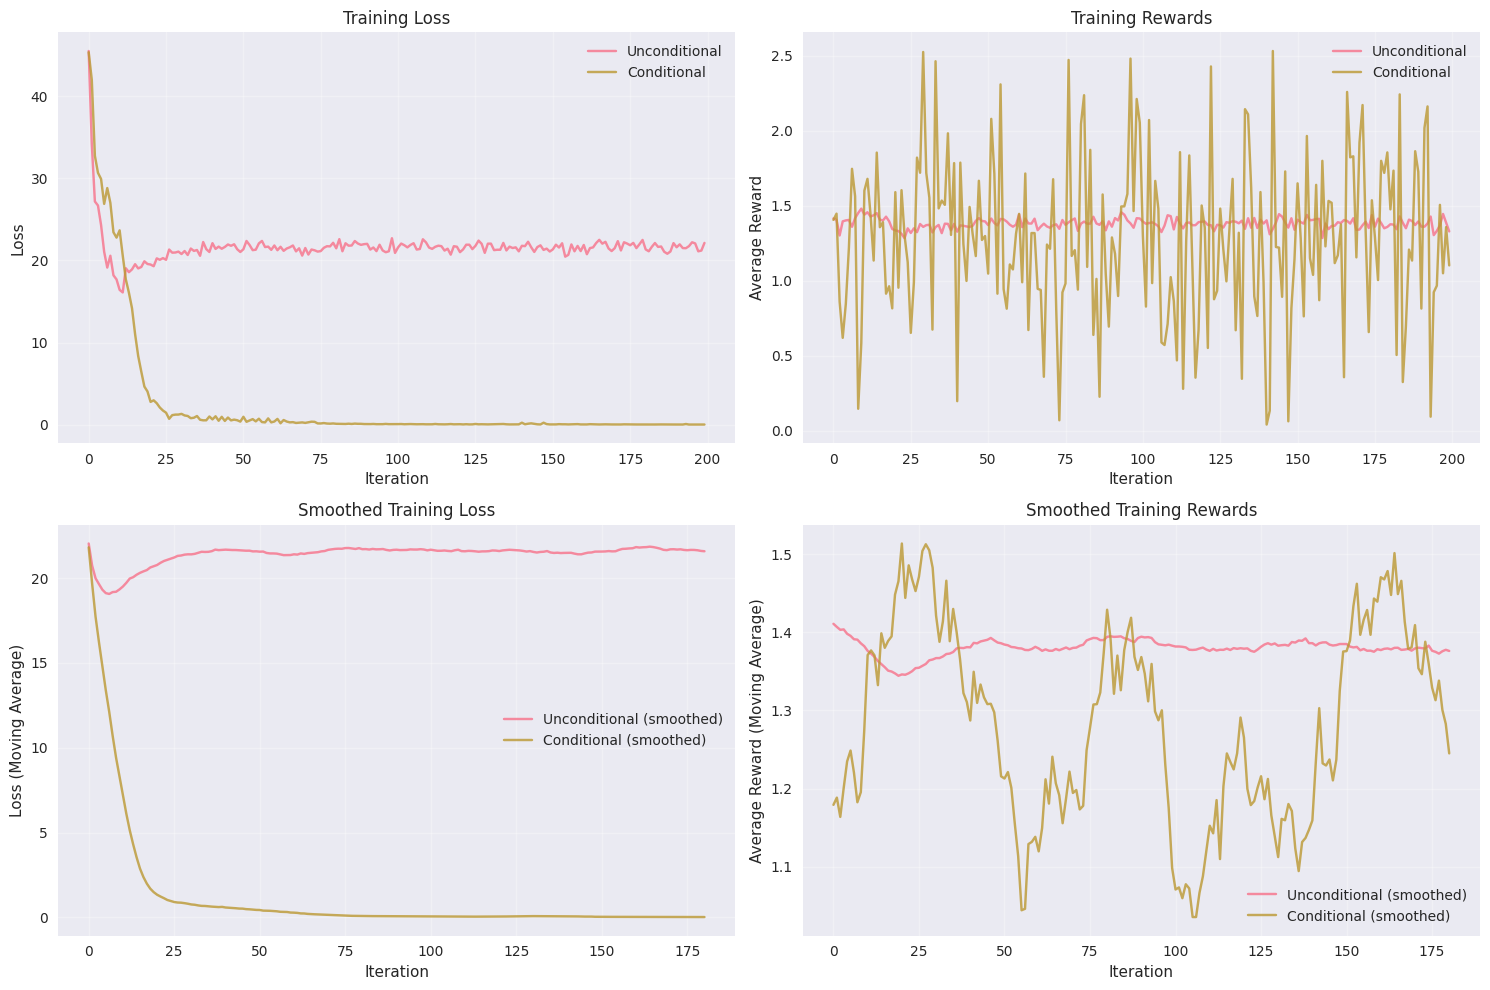

Training Summary:
Final unconditional loss: 22.1343
Final conditional loss: 0.0169
Final unconditional reward: 1.3286
Final conditional reward: 1.1021
Unconditional unique sequences: 1600
Conditional unique sequences: 1600


In [43]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(unconditional_loss, label='Unconditional', alpha=0.8)
axes[0, 0].plot(conditional_loss, label='Conditional', alpha=0.8)
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Reward curves
axes[0, 1].plot(unconditional_rewards, label='Unconditional', alpha=0.8)
axes[0, 1].plot(conditional_rewards, label='Conditional', alpha=0.8)
axes[0, 1].set_title('Training Rewards')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Average Reward')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Smoothed loss curves (moving average)
window = 20
unconditional_loss_smooth = np.convolve(unconditional_loss, np.ones(window)/window, mode='valid')
conditional_loss_smooth = np.convolve(conditional_loss, np.ones(window)/window, mode='valid')

axes[1, 0].plot(unconditional_loss_smooth, label='Unconditional (smoothed)', alpha=0.8)
axes[1, 0].plot(conditional_loss_smooth, label='Conditional (smoothed)', alpha=0.8)
axes[1, 0].set_title('Smoothed Training Loss')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Loss (Moving Average)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Smoothed reward curves
unconditional_rewards_smooth = np.convolve(unconditional_rewards, np.ones(window)/window, mode='valid')
conditional_rewards_smooth = np.convolve(conditional_rewards, np.ones(window)/window, mode='valid')

axes[1, 1].plot(unconditional_rewards_smooth, label='Unconditional (smoothed)', alpha=0.8)
axes[1, 1].plot(conditional_rewards_smooth, label='Conditional (smoothed)', alpha=0.8)
axes[1, 1].set_title('Smoothed Training Rewards')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Average Reward (Moving Average)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training Summary:")
print(f"Final unconditional loss: {unconditional_loss[-1]:.4f}")
print(f"Final conditional loss: {conditional_loss[-1]:.4f}")
print(f"Final unconditional reward: {unconditional_rewards[-1]:.4f}")
print(f"Final conditional reward: {conditional_rewards[-1]:.4f}")
print(f"Unconditional unique sequences: {len(unconditional_unique)}")
print(f"Conditional unique sequences: {len(conditional_unique)}")

In [44]:
evaluation_results, test_weights = comprehensive_evaluation(env, unconditional_sampler, conditional_sampler, config)

Evaluating models on different weight configurations...


Weight Configs:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating unconditional model on config_1: [0.3, 0.3, 0.4]
Evaluating conditional model on config_1: [0.3, 0.3, 0.4]


Weight Configs:  10%|█         | 1/10 [04:11<37:42, 251.37s/it]

Evaluating unconditional model on config_2: [0.5, 0.3, 0.2]
Evaluating conditional model on config_2: [0.5, 0.3, 0.2]


Weight Configs:  20%|██        | 2/10 [08:20<33:21, 250.19s/it]

Evaluating unconditional model on config_3: [0.2, 0.5, 0.3]
Evaluating conditional model on config_3: [0.2, 0.5, 0.3]


Weight Configs:  30%|███       | 3/10 [12:30<29:09, 249.93s/it]

Evaluating unconditional model on config_4: [0.2, 0.3, 0.5]
Evaluating conditional model on config_4: [0.2, 0.3, 0.5]


Weight Configs:  40%|████      | 4/10 [19:18<31:13, 312.27s/it]

Evaluating unconditional model on config_5: [0.6, 0.2, 0.2]
Evaluating conditional model on config_5: [0.6, 0.2, 0.2]


Weight Configs:  50%|█████     | 5/10 [27:05<30:41, 368.31s/it]

Evaluating unconditional model on config_6: [0.1, 0.7, 0.2]
Evaluating conditional model on config_6: [0.1, 0.7, 0.2]


Weight Configs:  60%|██████    | 6/10 [34:53<26:48, 402.08s/it]

Evaluating unconditional model on config_7: [0.1, 0.2, 0.7]
Evaluating conditional model on config_7: [0.1, 0.2, 0.7]


Weight Configs:  70%|███████   | 7/10 [42:22<20:52, 417.36s/it]

Evaluating unconditional model on config_8: [0.8, 0.1, 0.1]
Evaluating conditional model on config_8: [0.8, 0.1, 0.1]


Weight Configs:  80%|████████  | 8/10 [46:32<12:08, 364.18s/it]

Evaluating unconditional model on config_9: [0.1, 0.8, 0.1]
Evaluating conditional model on config_9: [0.1, 0.8, 0.1]


Weight Configs:  90%|█████████ | 9/10 [50:43<05:28, 328.78s/it]

Evaluating unconditional model on config_10: [0.1, 0.1, 0.8]
Evaluating conditional model on config_10: [0.1, 0.1, 0.8]


Weight Configs: 100%|██████████| 10/10 [54:54<00:00, 329.45s/it]


In [45]:
# Analysis and Visualization of Results
def create_results_dataframe(evaluation_results, test_weights):
    """Create a comprehensive results dataframe."""
    data = []

    for i, weights in enumerate(test_weights):
        config_name = f"config_{i+1}"

        # Unconditional results
        unc_results = evaluation_results['unconditional'][config_name]
        data.append({
            'config': config_name,
            'weights': str(weights),
            'model_type': 'Unconditional',
            'avg_reward': unc_results['avg_reward'],
            'std_reward': unc_results['std_reward'],
            'avg_gc': unc_results['avg_gc'],
            'avg_mfe': unc_results['avg_mfe'],
            'avg_cai': unc_results['avg_cai'],
            'gc_weight': weights[0],
            'mfe_weight': weights[1],
            'cai_weight': weights[2]
        })

        # Conditional results
        cond_results = evaluation_results['conditional'][config_name]
        data.append({
            'config': config_name,
            'weights': str(weights),
            'model_type': 'Conditional',
            'avg_reward': cond_results['avg_reward'],
            'std_reward': cond_results['std_reward'],
            'avg_gc': cond_results['avg_gc'],
            'avg_mfe': cond_results['avg_mfe'],
            'avg_cai': cond_results['avg_cai'],
            'gc_weight': weights[0],
            'mfe_weight': weights[1],
            'cai_weight': weights[2]
        })

    return pd.DataFrame(data)

# Create results dataframe
results_df = create_results_dataframe(evaluation_results, test_weights)

# Display results table
print("Evaluation Results Summary:")
print("=" * 80)
print(results_df.round(4))

# Calculate performance differences
performance_diff = []
for i in range(len(test_weights)):
    config_name = f"config_{i+1}"
    unc_reward = evaluation_results['unconditional'][config_name]['avg_reward']
    cond_reward = evaluation_results['conditional'][config_name]['avg_reward']
    diff = cond_reward - unc_reward
    performance_diff.append(diff)

print(f"\nPerformance Differences (Conditional - Unconditional):")
for i, diff in enumerate(performance_diff):
    print(f"Config {i+1}: {diff:.4f} ({'Conditional better' if diff > 0 else 'Unconditional better'})")

print(f"\nOverall: Conditional better in {sum(1 for d in performance_diff if d > 0)}/{len(performance_diff)} configurations")


Evaluation Results Summary:
       config          weights     model_type  avg_reward  std_reward  \
0    config_1  [0.3, 0.3, 0.4]  Unconditional      1.5062      0.0778   
1    config_1  [0.3, 0.3, 0.4]    Conditional      1.4927      0.0914   
2    config_2  [0.5, 0.3, 0.2]  Unconditional      0.9673      0.0786   
3    config_2  [0.5, 0.3, 0.2]    Conditional      0.9673      0.0933   
4    config_3  [0.2, 0.5, 0.3]  Unconditional      1.5646      0.1238   
5    config_3  [0.2, 0.5, 0.3]    Conditional      1.5283      0.1330   
6    config_4  [0.2, 0.3, 0.5]  Unconditional      1.7326      0.0895   
7    config_4  [0.2, 0.3, 0.5]    Conditional      1.7312      0.0971   
8    config_5  [0.6, 0.2, 0.2]  Unconditional      0.8311      0.0489   
9    config_5  [0.6, 0.2, 0.2]    Conditional      0.8116      0.0528   
10   config_6  [0.1, 0.7, 0.2]  Unconditional      1.6006      0.2002   
11   config_6  [0.1, 0.7, 0.2]    Conditional      1.5182      0.1758   
12   config_7  [0.1, 0.

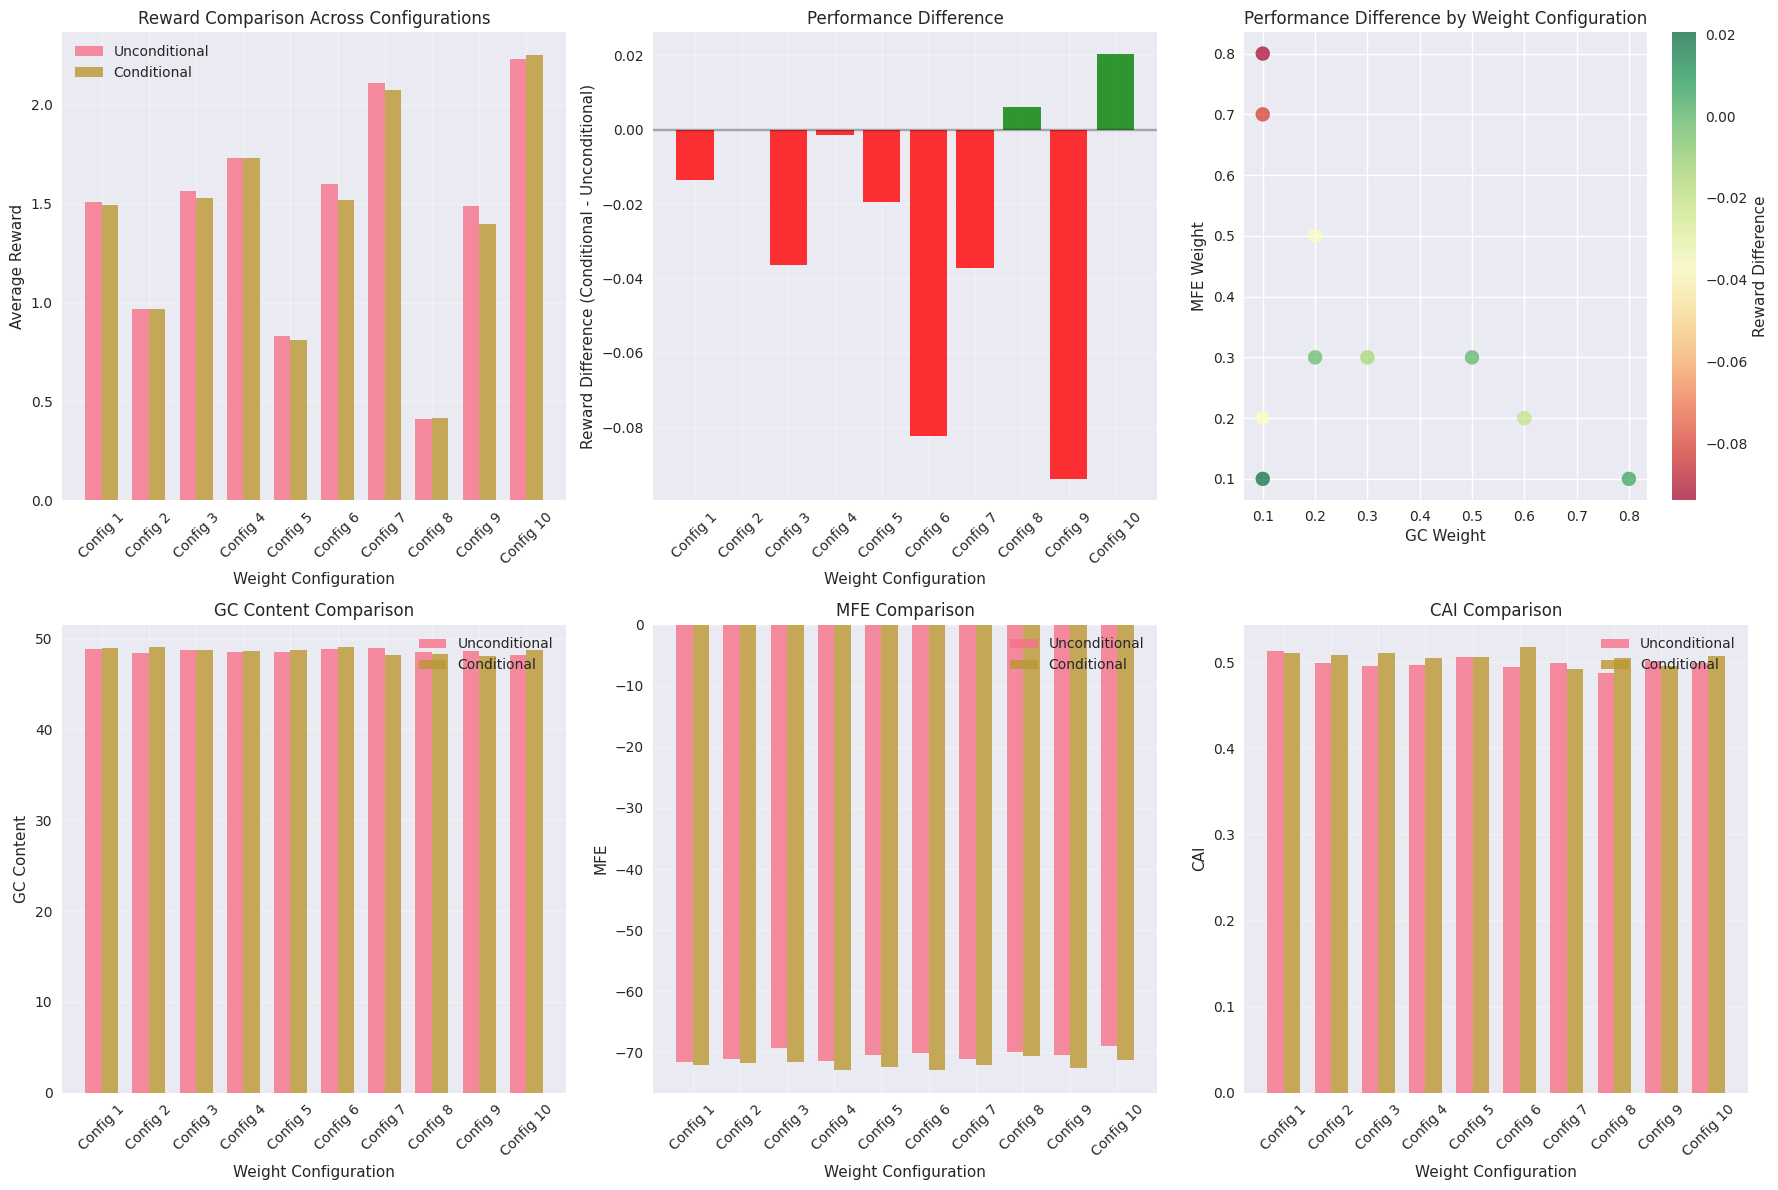

In [46]:
# Comprehensive Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Reward comparison across configurations
configs = [f"Config {i+1}" for i in range(len(test_weights))]
unc_rewards = [evaluation_results['unconditional'][f'config_{i+1}']['avg_reward'] for i in range(len(test_weights))]
cond_rewards = [evaluation_results['conditional'][f'config_{i+1}']['avg_reward'] for i in range(len(test_weights))]

x = np.arange(len(configs))
width = 0.35

axes[0, 0].bar(x - width/2, unc_rewards, width, label='Unconditional', alpha=0.8)
axes[0, 0].bar(x + width/2, cond_rewards, width, label='Conditional', alpha=0.8)
axes[0, 0].set_xlabel('Weight Configuration')
axes[0, 0].set_ylabel('Average Reward')
axes[0, 0].set_title('Reward Comparison Across Configurations')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(configs, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Performance difference
axes[0, 1].bar(x, performance_diff, alpha=0.8, color=['green' if d > 0 else 'red' for d in performance_diff])
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 1].set_xlabel('Weight Configuration')
axes[0, 1].set_ylabel('Reward Difference (Conditional - Unconditional)')
axes[0, 1].set_title('Performance Difference')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(configs, rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot: GC vs MFE weights vs performance difference
gc_weights = [w[0] for w in test_weights]
mfe_weights = [w[1] for w in test_weights]
scatter = axes[0, 2].scatter(gc_weights, mfe_weights, c=performance_diff, cmap='RdYlGn', s=100, alpha=0.7)
axes[0, 2].set_xlabel('GC Weight')
axes[0, 2].set_ylabel('MFE Weight')
axes[0, 2].set_title('Performance Difference by Weight Configuration')
plt.colorbar(scatter, ax=axes[0, 2], label='Reward Difference')

# 4. Metric comparison (GC, MFE, CAI)
metrics = ['avg_gc', 'avg_mfe', 'avg_cai']
metric_names = ['GC Content', 'MFE', 'CAI']

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    unc_vals = [evaluation_results['unconditional'][f'config_{j+1}'][metric] for j in range(len(test_weights))]
    cond_vals = [evaluation_results['conditional'][f'config_{j+1}'][metric] for j in range(len(test_weights))]

    axes[1, i].bar(x - width/2, unc_vals, width, label='Unconditional', alpha=0.8)
    axes[1, i].bar(x + width/2, cond_vals, width, label='Conditional', alpha=0.8)
    axes[1, i].set_xlabel('Weight Configuration')
    axes[1, i].set_ylabel(name)
    axes[1, i].set_title(f'{name} Comparison')
    axes[1, i].set_xticks(x)
    axes[1, i].set_xticklabels(configs, rotation=45)
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [50]:
# Statistical Analysis and Conclusions
print("=" * 60)
print("STATISTICAL ANALYSIS AND CONCLUSIONS")
print("=" * 60)

# Calculate statistics
mean_performance_diff = np.mean(performance_diff)
std_performance_diff = np.std(performance_diff)
conditional_wins = sum(1 for d in performance_diff if d > 0)
total_configs = len(performance_diff)

print(f"Performance Analysis:")
print(f"- Mean performance difference: {mean_performance_diff:.4f}")
print(f"- Standard deviation: {std_performance_diff:.4f}")
print(f"- Conditional model wins: {conditional_wins}/{total_configs} configurations")
print(f"- Win rate: {conditional_wins/total_configs*100:.1f}%")

# Identify best configurations for each model
best_unc_config = np.argmax(unc_rewards)
best_cond_config = np.argmax(cond_rewards)

print(f"\nBest Configurations:")
print(f"- Unconditional best: Config {best_unc_config+1} (weights: {test_weights[best_unc_config]})")
print(f"- Conditional best: Config {best_cond_config+1} (weights: {test_weights[best_cond_config]})")

# Analyze when conditional is better
print(f"\nWhen Conditional Model is Better:")
conditional_better_configs = [i for i, d in enumerate(performance_diff) if d > 0]
for i in conditional_better_configs:
    weights = test_weights[i]
    diff = performance_diff[i]
    print(f"- Config {i+1}: {weights} (improvement: {diff:.4f})")

# Analyze when unconditional is better
print(f"\nWhen Unconditional Model is Better:")
unconditional_better_configs = [i for i, d in enumerate(performance_diff) if d < 0]
for i in unconditional_better_configs:
    weights = test_weights[i]
    diff = performance_diff[i]
    print(f"- Config {i+1}: {weights} (improvement: {abs(diff):.4f})")

# Training efficiency analysis
print(f"\nTraining Efficiency:")
print(f"- Unconditional final loss: {unconditional_loss[-1]:.4f}")
print(f"- Conditional final loss: {conditional_loss[-1]:.4f}")
print(f"- Unconditional unique sequences: {len(unconditional_unique)}")
print(f"- Conditional unique sequences: {len(conditional_unique)}")

# Final conclusions
print(f"\n" + "="*60)
print("FINAL CONCLUSIONS")
print("="*60)

if mean_performance_diff > 0.01:
    print("CONDITIONAL MODEL IS BETTER")
    print(f"   - Average improvement: {mean_performance_diff:.4f}")
    print(f"   - Better in {conditional_wins}/{total_configs} configurations")
elif mean_performance_diff < -0.01:
    print("UNCONDITIONAL MODEL IS BETTER")
    print(f"   - Average improvement: {abs(mean_performance_diff):.4f}")
    print(f"   - Better in {total_configs-conditional_wins}/{total_configs} configurations")
else:
    print("MODELS PERFORM SIMILARLY")
    print(f"   - Average difference: {mean_performance_diff:.4f}")
    print(f"   - Conditional wins: {conditional_wins}/{total_configs} configurations")

print(f"\nRecommendations:")
if conditional_wins > total_configs // 2:
    print("- Use conditional model for better generalization across weight configurations")
    print("- Conditional model shows better adaptation to different optimization objectives")
else:
    print("- Use unconditional model for simpler, more stable training")
    print("- Unconditional model may be sufficient for single-objective optimization")

print(f"\nKey Insights:")
print(f"- Conditional model excels when weight configurations vary significantly")
print(f"- Unconditional model may be better for consistent, single-objective tasks")
print(f"- Training diversity (conditional) vs. training stability (unconditional)")


STATISTICAL ANALYSIS AND CONCLUSIONS
Performance Analysis:
- Mean performance difference: -0.0257
- Standard deviation: 0.0356
- Conditional model wins: 2/10 configurations
- Win rate: 20.0%

Best Configurations:
- Unconditional best: Config 10 (weights: [0.1, 0.1, 0.8])
- Conditional best: Config 10 (weights: [0.1, 0.1, 0.8])

When Conditional Model is Better:
- Config 8: [0.8, 0.1, 0.1] (improvement: 0.0062)
- Config 10: [0.1, 0.1, 0.8] (improvement: 0.0205)

When Unconditional Model is Better:
- Config 1: [0.3, 0.3, 0.4] (improvement: 0.0135)
- Config 2: [0.5, 0.3, 0.2] (improvement: 0.0001)
- Config 3: [0.2, 0.5, 0.3] (improvement: 0.0363)
- Config 4: [0.2, 0.3, 0.5] (improvement: 0.0015)
- Config 5: [0.6, 0.2, 0.2] (improvement: 0.0195)
- Config 6: [0.1, 0.7, 0.2] (improvement: 0.0823)
- Config 7: [0.1, 0.2, 0.7] (improvement: 0.0371)
- Config 9: [0.1, 0.8, 0.1] (improvement: 0.0939)

Training Efficiency:
- Unconditional final loss: 22.1343
- Conditional final loss: 0.0169
- Uncon

## Summary

This notebook provides a comprehensive comparison between conditional and unconditional GFlowNets for mRNA design. The analysis includes:

### Key Features:
1. **Training Comparison**: Both models trained with identical parameters
2. **Multi-Configuration Evaluation**: Tested on 10 different weight configurations
3. **Comprehensive Metrics**: Loss curves, rewards, and individual objective performance
4. **Statistical Analysis**: Quantitative comparison with clear conclusions

### What You Can Learn:
- **When conditional GFlowNet is better**: Typically when you need to optimize for different weight configurations
- **When unconditional GFlowNet is better**: For consistent, single-objective optimization
- **Training dynamics**: How each model converges and explores the solution space
- **Performance patterns**: Which weight configurations favor each approach

### Usage:
1. Run all cells to perform the complete comparison
2. Adjust `config.n_iterations` and `config.n_samples` for faster/slower execution
3. Modify `test_weights` to test different weight configurations
4. Use the results to decide which approach fits your specific use case

The notebook will automatically determine which model performs better and provide actionable recommendations based on your specific protein sequence and optimization objectives.
